In [1]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os

In [2]:
import PF
import ROI
importlib.reload(PF)
importlib.reload(ROI)

<module 'ROI' from 'C:\\Users\\krq\\Documents\\GitHub\\radwatch-analysis\\ROI.py'>

In [3]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()


def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))

    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
       

In [4]:
spec = r'C:\rad data\Radwatch data\efficiency_calibration_2020-3-5.Spe'
bg = r'C:\rad data\Radwatch data\Background_Spectrum_12_20_19.Spe'
spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)

SpeFile: Reading file C:\rad data\Radwatch data\efficiency_calibration_2020-3-5.Spe


C:\anaconda3\lib\site-packages\becquerel\parsers\spectrum_file.py:136: SpectrumFileParsingWarning: Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.
  SpectrumFileParsingWarning)


SpeFile: Reading file C:\rad data\Radwatch data\Background_Spectrum_12_20_19.Spe


In [5]:
# apply the kernel to the data to get SNR
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

C:\anaconda3\lib\site-packages\becquerel\core\peakfinder.py:181: DeprecationWarning: channels is deprecated and will be removed in a future release. Use centroids instead.
  'release. Use centroids instead.', DeprecationWarning)


[506.5, 793.5, 914.5, 1345.5, 2111.5, 3881.5, 3950.5, 7107.5]


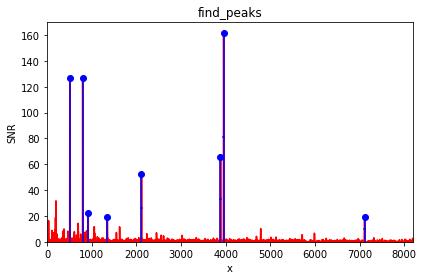

In [6]:
cal.peakfinder.find_peaks(min_snr=15, xmin=400)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 0.369757 keV/channel
fit gain: 0.369756699383546 keV/channel
fit channels: [ 914.5 3881.5 3950.5 7107.5]


C:\anaconda3\lib\site-packages\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)


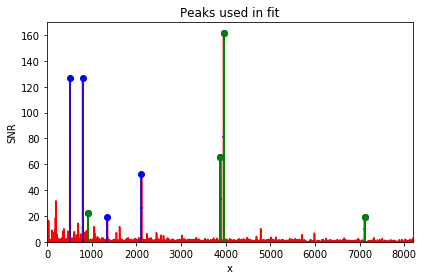

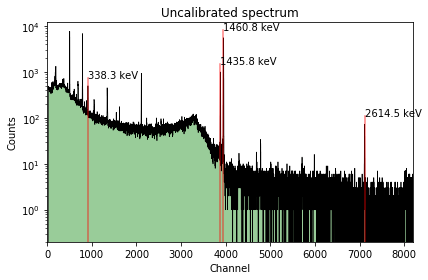

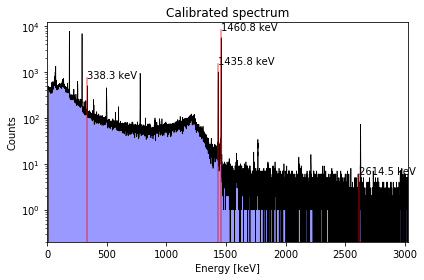

In [7]:
# perform calibration
cal.fit(
    [1435.795, 1460.82,2614.51],
    optional=[201.83,306.78, 351.93, 338.32,569.33,604.721,788.742,795.864, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.3, 10],
    de_max=100.,
)
plot_calibrator(cal)
#plot_spec(cal.peakfinder.spectrum, xmode='energy')
spectrum = cal.peakfinder.spectrum


[246.5, 539.5, 706.5, 1564.5, 1792.5, 1874.5, 2827.5, 4560.5, 5518.5]


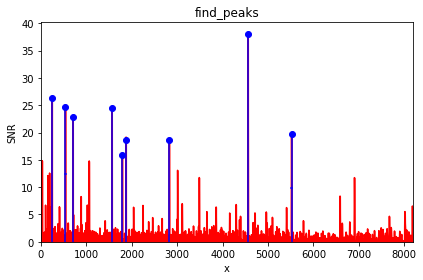

In [8]:
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(bg, kernel)
cal = bq.AutoCalibrator(finder)
cal.peakfinder.find_peaks(min_snr=15, xmin=200)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 0.320388 keV/channel
fit gain: 0.3203875656420919 keV/channel
fit channels: [2827.5 4560.5 5518.5]


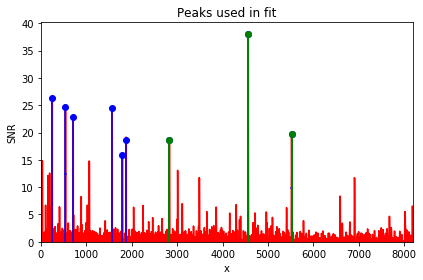

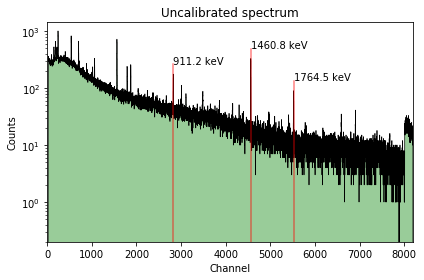

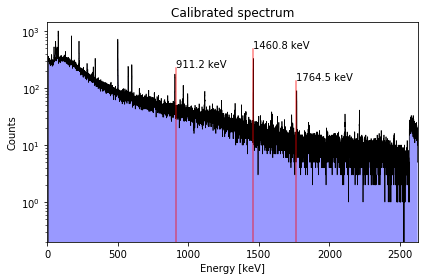

In [9]:
# perform calibration
cal.fit(
    [1460.82, 1764.49],
    optional=[186.21,238.63,609.32,911.20,242.00,295.22,338.32,351.93,1620.50],
    gain_range=[2.5e-2, 10],
    de_max=100.,
)
plot_calibrator(cal)
background = cal.peakfinder.spectrum

In [10]:
#Find Lu-176
source_isotopes = np.array(['Lu_176_1','Lu_176_2']); #get counts under the peak subtrack the background
source_energies = np.array([201.83,306.78]);
source_activities = np.array([1]);
branching_ratio = np.array([1]);

In [11]:
roi = ROI.ROI(spectrum, background, source_energies, sub_type = 0)
roi_result = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print('Lu_176 ROI result:',roi_result)
#print('Lu_176 PF result:',pf_result)

Lu_176 ROI result: ([-621.8672952645, -206.19173581108112], [86.68726683933838, 60.516593527894436])


In [12]:
spec = spectrum
counts = spec.counts_vals
energies = spec.energies_kev

def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx

545
201.70227951372436


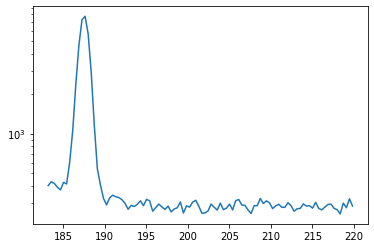

In [13]:
#Testing Lu-176_201.83keV
Lu_176_idx0 = f_near(energies,source_energies[0]) 
print(Lu_176_idx0)
print(energies[Lu_176_idx0])
roi_low = Lu_176_idx0 - 50
roi_high = Lu_176_idx0 + 50

#slice the counts array: select counts[starts-index:stop-index]
plot_counts = counts[roi_low:roi_high]
plot_energies = energies[roi_low:roi_high]

#print(len(counts))
#print(len(plot_counts))

plt.plot(plot_energies,plot_counts)
plt.yscale('log')

In [14]:
roi.find_peak_energies()
print(roi.target_peaks)

[201. 309.]


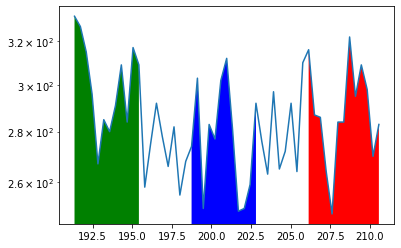

In [15]:
roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.target_peaks[0])
rlow = roi_low_bins[0][0]
rhi = roi_high_bins[0][-1]
plot_counts = counts[rlow:rhi]
plot_energies = energies[rlow:rhi]

rlow = roi_low_bins[0][0]
rhi = roi_low_bins[0][-1]
low_counts = counts[rlow:rhi]
low_energies = energies[rlow:rhi]

rlow = roi_high_bins[0][0]
rhi = roi_high_bins[0][-1]
high_counts = counts[rlow:rhi]
high_energies = energies[rlow:rhi]

rlow = roi_peak_bins[0][0]
rhi = roi_peak_bins[0][-1]
peak_counts = counts[rlow:rhi]
peak_energies = energies[rlow:rhi]

fig,ax = plt.subplots()
ax.plot(plot_energies,plot_counts)

ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
ax.set_yscale('log')

835
308.93172233495267


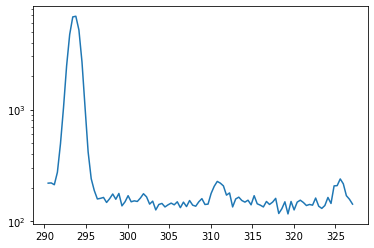

In [16]:
#Testing Lu-176_306.78keV
Lu_176_idx1 = f_near(energies,source_energies[1]) 
print(Lu_176_idx1)
print(energies[Lu_176_idx1])
roi_low = Lu_176_idx1 - 50
roi_high = Lu_176_idx1 + 50

#slice the counts array: select counts[starts-index:stop-index]
plot_counts = counts[roi_low:roi_high]
plot_energies = energies[roi_low:roi_high]

#print(len(counts))
#print(len(plot_counts))

plt.plot(plot_energies,plot_counts)
plt.yscale('log')

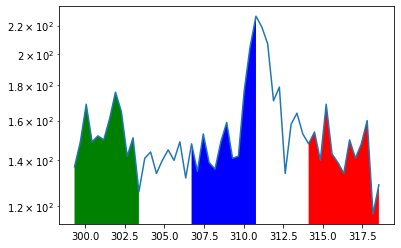

In [17]:
roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.target_peaks[1])
rlow = roi_low_bins[0][0]
rhi = roi_high_bins[0][-1]
plot_counts = counts[rlow:rhi]
plot_energies = energies[rlow:rhi]

rlow = roi_low_bins[0][0]
rhi = roi_low_bins[0][-1]
low_counts = counts[rlow:rhi]
low_energies = energies[rlow:rhi]

rlow = roi_high_bins[0][0]
rhi = roi_high_bins[0][-1]
high_counts = counts[rlow:rhi]
high_energies = energies[rlow:rhi]

rlow = roi_peak_bins[0][0]
rhi = roi_peak_bins[0][-1]
peak_counts = counts[rlow:rhi]
peak_energies = energies[rlow:rhi]

fig,ax = plt.subplots()
ax.plot(plot_energies,plot_counts)

ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
ax.set_yscale('log')

In [18]:
#Find La-138
source_isotopes = np.array(['La_138_1','La_138_2']); #get counts under the peak subtrack the background
source_energies = np.array([788.742,1435.795]);
source_activities = np.array([1]);
branching_ratio = np.array([1]);

In [19]:
roi = ROI.ROI(spectrum, background, source_energies, sub_type = 0)
roi_result = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print('La_138 ROI result:',roi_result)
#print('La_138 PF result:',pf_result)

La_138 ROI result: ([-2330.5265631756984, 6033.318648986175], [51.33349417768342, 80.41357998568049])


In [20]:
roi.find_peak_energies()
print(roi.target_peaks)

[ 789. 1436.]


2133
788.8759181347954


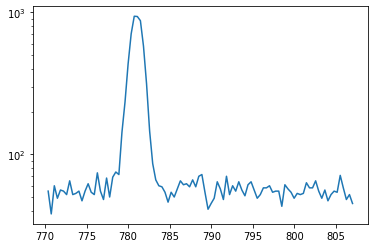

In [21]:
#Testing La-138_788.742keV
La_138_idx0 = f_near(energies,source_energies[0]) 
print(La_138_idx0)
print(energies[La_138_idx0])
roi_low = La_138_idx0 - 50
roi_high = La_138_idx0 + 50

#slice the counts array: select counts[starts-index:stop-index]
plot_counts = counts[roi_low:roi_high]
plot_energies = energies[roi_low:roi_high]

#print(len(counts))
#print(len(plot_counts))

plt.plot(plot_energies,plot_counts)
plt.yscale('log')

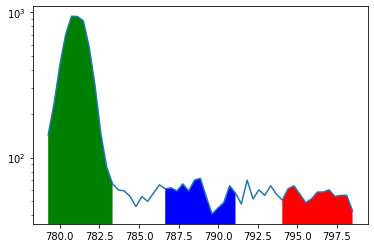

In [22]:
roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.target_peaks[0])
rlow = roi_low_bins[0][0]
rhi = roi_high_bins[0][-1]
plot_counts = counts[rlow:rhi]
plot_energies = energies[rlow:rhi]

rlow = roi_low_bins[0][0]
rhi = roi_low_bins[0][-1]
low_counts = counts[rlow:rhi]
low_energies = energies[rlow:rhi]

rlow = roi_high_bins[0][0]
rhi = roi_high_bins[0][-1]
high_counts = counts[rlow:rhi]
high_energies = energies[rlow:rhi]

rlow = roi_peak_bins[0][0]
rhi = roi_peak_bins[0][-1]
peak_counts = counts[rlow:rhi]
peak_energies = energies[rlow:rhi]

fig,ax = plt.subplots()
ax.plot(plot_energies,plot_counts)

ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
ax.set_yscale('log')

3883
1435.950142056001


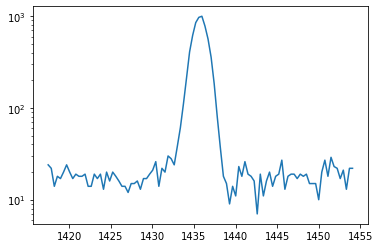

In [23]:
#Testing La-138_788.742keV
La_138_idx1 = f_near(energies,source_energies[1]) 
print(La_138_idx1)
print(energies[La_138_idx1])
roi_low = La_138_idx1 - 50
roi_high = La_138_idx1 + 50

#slice the counts array: select counts[starts-index:stop-index]
plot_counts = counts[roi_low:roi_high]
plot_energies = energies[roi_low:roi_high]

#print(len(counts))
#print(len(plot_counts))

plt.plot(plot_energies,plot_counts)
plt.yscale('log')

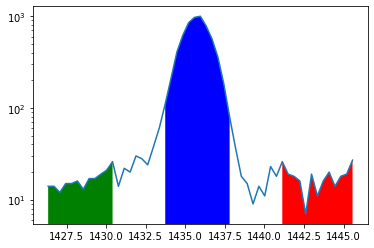

In [24]:
roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.target_peaks[1])
rlow = roi_low_bins[0][0]
rhi = roi_high_bins[0][-1]
plot_counts = counts[rlow:rhi]
plot_energies = energies[rlow:rhi]

rlow = roi_low_bins[0][0]
rhi = roi_low_bins[0][-1]
low_counts = counts[rlow:rhi]
low_energies = energies[rlow:rhi]

rlow = roi_high_bins[0][0]
rhi = roi_high_bins[0][-1]
high_counts = counts[rlow:rhi]
high_energies = energies[rlow:rhi]

rlow = roi_peak_bins[0][0]
rhi = roi_peak_bins[0][-1]
peak_counts = counts[rlow:rhi]
peak_energies = energies[rlow:rhi]

fig,ax = plt.subplots()
ax.plot(plot_energies,plot_counts)

ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
ax.set_yscale('log')

In [25]:
#K-40
source_isotopes = np.array(['K-40']); #get counts under the peak subtrack the background
source_energies = np.array([1460]);
source_activities = np.array([1]);
branching_ratio = np.array([1]);

In [26]:
roi = ROI.ROI(spectrum, background, source_energies, sub_type = 0)
roi_result = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print('K_40 ROI result:',roi_result)
#print('La_138 PF result:',pf_result)

K_40 ROI result: ([29608.465347635083], [173.2745232171009])


3948
1459.9843275159315


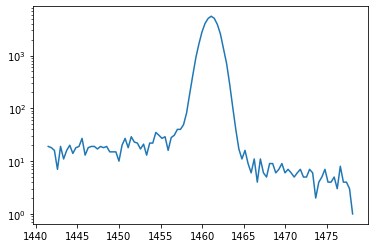

In [27]:
K_40_idx1 = f_near(energies,source_energies[0]) 
print(K_40_idx1)
print(energies[K_40_idx1])
roi_low = K_40_idx1 - 50
roi_high = K_40_idx1 + 50

#slice the counts array: select counts[starts-index:stop-index]
plot_counts = counts[roi_low:roi_high]
plot_energies = energies[roi_low:roi_high]

#print(len(counts))
#print(len(plot_counts))

plt.plot(plot_energies,plot_counts)
plt.yscale('log')

In [28]:
roi.find_peak_energies()
print(roi.target_peaks)

[1461]


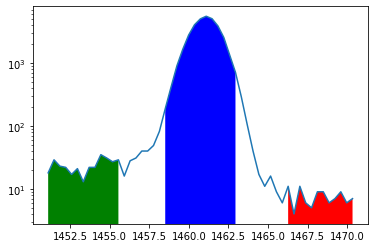

In [29]:
roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.target_peaks[0])
rlow = roi_low_bins[0][0]
rhi = roi_high_bins[0][-1]
plot_counts = counts[rlow:rhi]
plot_energies = energies[rlow:rhi]

rlow = roi_low_bins[0][0]
rhi = roi_low_bins[0][-1]
low_counts = counts[rlow:rhi]
low_energies = energies[rlow:rhi]

rlow = roi_high_bins[0][0]
rhi = roi_high_bins[0][-1]
high_counts = counts[rlow:rhi]
high_energies = energies[rlow:rhi]

rlow = roi_peak_bins[0][0]
rhi = roi_peak_bins[0][-1]
peak_counts = counts[rlow:rhi]
peak_energies = energies[rlow:rhi]

fig,ax = plt.subplots()
ax.plot(plot_energies,plot_counts)

ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
ax.set_yscale('log')